# Backpropagation for train a deep multilayer neural network

# Losses in PyTorch

In [ ]:
#solve the issue of downloading MNIST dataset
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [3]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])
# Download and load the training data
trainset = datasets.MNIST('/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

Using downloaded and verified file: /MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz
Extracting /MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /MNIST_data/MNIST/raw
Using downloaded and verified file: /MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz
Extracting /MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /MNIST_data/MNIST/raw
Using downloaded and verified file: /MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting /MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /MNIST_data/MNIST/raw



Extracting /MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /MNIST_data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Using the cross-entropy as a loss function

In [4]:
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10))

# Define the loss
criterion = nn.CrossEntropyLoss()

# Get our data
images, labels = next(iter(trainloader))
# Flatten images
images = images.view(images.shape[0], -1)

# Forward pass, get our logits
logits = model(images)
# Calculate the loss with the logits and the labels
loss = criterion(logits, labels)

print(loss)

tensor(2.3187, grad_fn=<NllLossBackward>)


# Using the negative log likelihood loss as a loss function

In [5]:
## Solution

# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

# Define the loss
criterion = nn.NLLLoss()

# Get our data
images, labels = next(iter(trainloader))
# Flatten images
images = images.view(images.shape[0], -1)

# Forward pass, get our log-probabilities
logps = model(images)
# Calculate the loss with the logps and the labels
loss = criterion(logps, labels)

print(loss)

tensor(2.2926, grad_fn=<NllLossBackward>)


# Autograd

The autograd module keeps track of these operations and knows how to calculate the gradient for each one. In this way, it's able to calculate the gradients for a chain of operations, with respect to any one tensor. 

In [ ]:
x = torch.randn(2,2, requires_grad=True)
print(x)

tensor([[-0.2561,  0.6748],
        [ 0.4683, -0.2937]], requires_grad=True)


In [ ]:
y = x**2
print(y)

tensor([[0.0656, 0.4554],
        [0.2193, 0.0863]], grad_fn=<PowBackward0>)


In [ ]:
## grad_fn shows the function that generated this variable
print(y.grad_fn)

In [ ]:
z = y.mean()
print(z)

tensor(0.2067, grad_fn=<MeanBackward0>)


In [ ]:
# You can check the gradients for x and y but they are empty currently.
print(x.grad)

None


In [ ]:
# The .backward method will calculate the gradient for z with respect to x
z.backward()
print(x.grad)
print(x/2)

tensor([[-0.1281,  0.3374],
        [ 0.2342, -0.1469]])
tensor([[-0.1281,  0.3374],
        [ 0.2342, -0.1469]], grad_fn=<DivBackward0>)


# Loss and Autograd together

In [6]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images)
loss = criterion(logps, labels)

In [7]:
print('Before backward pass: \n', model[0].weight.grad)

loss.backward()

print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[-1.1751e-03, -1.1751e-03, -1.1751e-03,  ..., -1.1751e-03,
         -1.1751e-03, -1.1751e-03],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 1.2487e-03,  1.2487e-03,  1.2487e-03,  ...,  1.2487e-03,
          1.2487e-03,  1.2487e-03],
        ...,
        [-2.7438e-04, -2.7438e-04, -2.7438e-04,  ..., -2.7438e-04,
         -2.7438e-04, -2.7438e-04],
        [-2.8165e-05, -2.8165e-05, -2.8165e-05,  ..., -2.8165e-05,
         -2.8165e-05, -2.8165e-05],
        [-5.2663e-03, -5.2663e-03, -5.2663e-03,  ..., -5.2663e-03,
         -5.2663e-03, -5.2663e-03]])


# Training the network!

# PyTorch optimizer to update the weights with the gradients.

In [8]:
from torch import optim

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [9]:
print('Initial weights - ', model[0].weight)

images, labels = next(iter(trainloader))
images.resize_(64, 784)

# Clear the gradients, do this because gradients are accumulated
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model(images)
loss = criterion(output, labels)
loss.backward()
print('Gradient -', model[0].weight.grad)

Initial weights -  Parameter containing:
tensor([[-0.0250, -0.0127,  0.0190,  ...,  0.0226, -0.0085, -0.0210],
        [ 0.0301, -0.0218,  0.0002,  ..., -0.0107,  0.0144,  0.0103],
        [ 0.0248,  0.0107, -0.0176,  ..., -0.0256, -0.0077, -0.0119],
        ...,
        [-0.0075,  0.0302,  0.0097,  ...,  0.0320,  0.0032, -0.0277],
        [ 0.0004,  0.0151, -0.0148,  ..., -0.0082,  0.0087,  0.0338],
        [-0.0219, -0.0225,  0.0049,  ..., -0.0019,  0.0010, -0.0146]],
       requires_grad=True)
Gradient - tensor([[-0.0013, -0.0013, -0.0013,  ..., -0.0013, -0.0013, -0.0013],
        [-0.0004, -0.0004, -0.0004,  ..., -0.0004, -0.0004, -0.0004],
        [ 0.0066,  0.0066,  0.0066,  ...,  0.0066,  0.0066,  0.0066],
        ...,
        [ 0.0005,  0.0005,  0.0005,  ...,  0.0005,  0.0005,  0.0005],
        [ 0.0011,  0.0011,  0.0011,  ...,  0.0011,  0.0011,  0.0011],
        [ 0.0005,  0.0005,  0.0005,  ...,  0.0005,  0.0005,  0.0005]])


In [10]:
# Take an update step and few the new weights
optimizer.step()
print('Updated weights - ', model[0].weight)

Updated weights -  Parameter containing:
tensor([[-0.0250, -0.0127,  0.0190,  ...,  0.0226, -0.0085, -0.0210],
        [ 0.0301, -0.0218,  0.0002,  ..., -0.0107,  0.0144,  0.0103],
        [ 0.0247,  0.0106, -0.0177,  ..., -0.0257, -0.0078, -0.0119],
        ...,
        [-0.0075,  0.0302,  0.0096,  ...,  0.0320,  0.0032, -0.0277],
        [ 0.0004,  0.0151, -0.0148,  ..., -0.0082,  0.0087,  0.0338],
        [-0.0219, -0.0225,  0.0049,  ..., -0.0019,  0.0010, -0.0146]],
       requires_grad=True)


# Training for real

In [11]:
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

epochs = 5
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # TODO: Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 1.8387502914806928
Training loss: 0.806986749553477
Training loss: 0.5130452767554631
Training loss: 0.42385983869020366
Training loss: 0.38189854839050186


# With the network trained, we can check out it's predictions.

In [12]:
#download the custom helper.py file to be able to desplay and view the image in the script below
!wget https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/3bd7dea850e936d8cb44adda8200e4e2b5d627e3/intro-to-pytorch/helper.py

--2021-03-17 01:29:43--  https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/3bd7dea850e936d8cb44adda8200e4e2b5d627e3/intro-to-pytorch/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2813 (2.7K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]   2.75K  --.-KB/s    in 0s      

2021-03-17 01:29:44 (49.6 MB/s) - ‘helper.py’ saved [2813/2813]



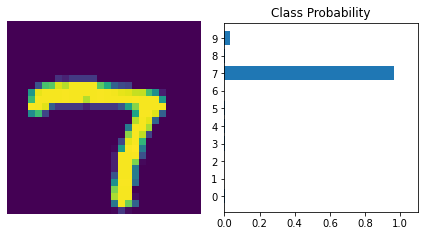

In [14]:
%matplotlib inline
import custom_helper

images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
custom_helper.view_classify(img.view(1, 28, 28), ps)
